In [1]:
import pandas as pd

In [2]:
url  = 'https://raw.githubusercontent.com/sandroormeno/TheBioMassters/main/features_metadata.csv'

In [3]:
df = pd.read_csv(url)
df.head()

,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,1049524,3953454613,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,1049524,3531005382,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,1049524,1401197002,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
3,0003d2eb_S1_03.tif,0003d2eb,S1,train,December,1049524,3253084255,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
4,0003d2eb_S1_04.tif,0003d2eb,S1,train,January,1049524,2467836265,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif


In [4]:
chip_id = df['chip_id'].unique()
len(chip_id)

11462

In [5]:
month = df['month'].unique()
month

array(['September', 'October', 'November', 'December', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August'],
      dtype=object)

In [6]:
ver = df['s3path_us'][0]
archivo = df['filename'][0]
ver, archivo

('s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_00.tif',
 '0003d2eb_S1_00.tif')

In [7]:
# all you need to install
%%capture
!pip install awscli
!pip install rasterio

In [8]:
%%capture
!aws s3 cp {ver} ./ --no-sign-request

In [9]:
import rasterio as rio
ds = rio.open(archivo)
ds.indexes

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(1, 2, 3, 4)

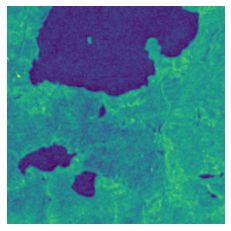

((256, 256), -22.103586, -3.264444, dtype('float32'))

In [10]:
import matplotlib.pyplot as plt
x = ds.read(1)
plt.imshow(x)
plt.axis('off')
plt.show()
x.shape, x.min(), x.max(), x.dtype

para S2 tenemos un total de 114882 imágenes.<br>
y para los meses:
- 'September': 6860,
- 'October': 6860,
- 'November': 6121,
- 'December': 1251,
- 'January': 5242,
- 'February': 6860,
- 'March': 8171,
- 'April': 8689,
- 'May': 8689,
- 'June': 8689,
- 'July': 8689,
- 'August': 8689


In [20]:
!rm -r sample_data

In [37]:
# esto crea las carpetas destino
import os
!rm -r '/content/data'
path_data = "data"
path_train = "train"
path_sep = "August"
path_sensor = ['s1', 's2', 's3']
os.mkdir(path_data)
os.mkdir(os.path.join(path_data, path_train))
os.mkdir(os.path.join(path_data, path_train,path_sep))
os.mkdir(os.path.join(path_data, path_train,path_sep,path_sensor[0]))
os.mkdir(os.path.join(path_data, path_train,path_sep,path_sensor[1]))
os.mkdir(os.path.join(path_data, path_train,path_sep,path_sensor[2]))

In [38]:
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from tqdm import tqdm 
import cv2
from numpy import savez_compressed
import warnings
from skimage.io import imread
from imageio import imwrite
warnings.filterwarnings("ignore")

months = ['September', 'October', 'November', 'December', 'January', 'February', 'March','April', 'May','June','July', 'August' ]
c_s1 = 0
c_s2 = 0
m = months[11]

def read_write_S1(intex):
  path = df['s3path_us'][intex]
  imagen = df['filename'][intex]
  # bajo las imagenes
  tem = !aws s3 cp {path} ./ --no-sign-request --quiet
  # guardo imagen
  x = imread(imagen)[...,(0,1,2)]
  s1 = np.clip(x, -30, 0)*(-8.4)/ 255.
  name_file = imagen.split('.')[0]
  out_path = f'data/train/{m}/s1/{name_file}.png'
  imwrite(f"{out_path}", np.round(s1*255).astype(np.uint8))
  !rm {imagen}

def read_write_S2(intex):
  path = df['s3path_us'][intex]
  imagen = df['filename'][intex]
  tem = !aws s3 cp {path} ./ --no-sign-request --quiet
  # imagen RGB
  ds = rio.open(imagen)
  r, g, b = ds.read(3), ds.read(2), ds.read(1) # tengo que bajar nuevamente 
  rgb = np.dstack((r,g,b))
  rgb = np.clip(rgb/4000, 0, 1)
  divide = np.max(rgb)/255
  salvar = rgb//divide
  imagen_salvar = imagen.split('.')[0]
  out_path = f'data/train/{m}/s2/{imagen_salvar}'
  cv2.imwrite(f"{out_path}.png", salvar) # en png
  #!rm {imagen} 

def read_write_S3(intex):
  #path = df['s3path_us'][intex]
  imagen = df['filename'][intex]
  #tem = !aws s3 cp {path} ./ --no-sign-request --quiet
  ds = rio.open(imagen)
  # ndv
  red = ds.read(3).astype(np.float32)
  nir = ds.read(7).astype(np.float32)
  ndvi_ = (nir - red) / (nir + red + 1e-8)
  ndvi_nom = (ndvi_+1)/2*255
  ndvi_final = ndvi_nom.astype(np.uint8)
  # ndwi
  swir = ds.read(9).astype(np.float32)
  nir = ds.read(7).astype(np.float32)
  ndwi_ = (nir - swir) / (nir + swir + 1e-8)
  ndwi_final = ((ndwi_+1)/2*255).astype(np.uint8)
  # clouds 
  clouds = ds.read(11).astype(np.uint8)
  clouds[clouds == 255] = 100
  # convino los tres canales
  rgb = np.dstack((ndvi_final,ndwi_final,clouds))
  # me quedo con el nombre el archivo sin tif
  name_file = imagen.split('.')[0]
  # genero un path para un nuevo folder S3, esto es porque tendrán el mismo nombre que S2
  out_path = f'data/train/{m}/s3/{name_file}.png'
  cv2.imwrite(out_path, rgb)
  !rm {imagen}

for i in tqdm(range(len(df))): #range(len(df))
  if df['satellite'][i] == 'S1':
    if df['split'][i] == 'train':
      if df['month'][i] == m:
        read_write_S1(i)

  if df['satellite'][i] == 'S2':
    if df['split'][i] == 'train':
      if df['month'][i] == months[11]:
        read_write_S2(i)
        read_write_S3(i)


100%|██████████| 252426/252426 [5:32:56<00:00, 12.64it/s]


In [39]:
# genero un zip y hago una copia en Dirve
%%capture
!zip -r data.zip data

In [40]:
!cp data.zip /content/drive/MyDrive

In [30]:
!rm *.tif